In [26]:
import numpy as np
import scanpy as sc
import scvelo as scv
import torch
from umap import UMAP
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
import pandas as pd

from deepvelo.utils import (
    velocity,
    velocity_confidence,
    continuity_confidence,
    update_dict,
    cross_boundary_correctness,
)
from deepvelo.utils.scatter import scatter
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

In [27]:
adata = scv.read("../velocyto/10X_multiome_mouse_brain.loom", cache = True)

In [28]:
adata.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata.obs_names]
adata.var_names_make_unique()

In [29]:
cell_annot = pd.read_csv('../cell_annotations.tsv', sep='\t', index_col=0)

In [30]:
adata = adata[cell_annot.index,:]
adata.obs['celltype'] = cell_annot['celltype']

In [31]:
adata = adata[adata.obs['celltype'].isin(['RG, Astro, OPC', 
                                                      'IPC', 
                                                      'V-SVZ', 
                                                      'Upper Layer', 
                                                      'Deeper Layer', 
                                                      'Ependymal cells', 
                                                      'Subplate'])]

In [32]:
adata.obs['celltype'] = cell_annot.loc[adata.obs_names, 'celltype']
adata.obs['celltype'] = adata.obs['celltype'].astype('category')

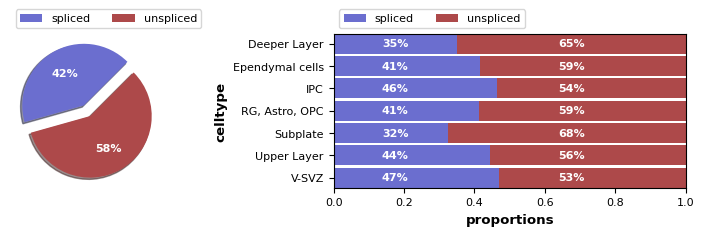

In [33]:
scv.pl.proportions(adata, groupby = "celltype")

In [34]:
scv.pp.filter_and_normalize(adata, min_shared_counts = 20, n_top_genes = 2000)
scv.pp.moments(adata, n_pcs = 30, n_neighbors = 30)

Filtered out 23038 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [35]:
sc.tl.leiden(adata)

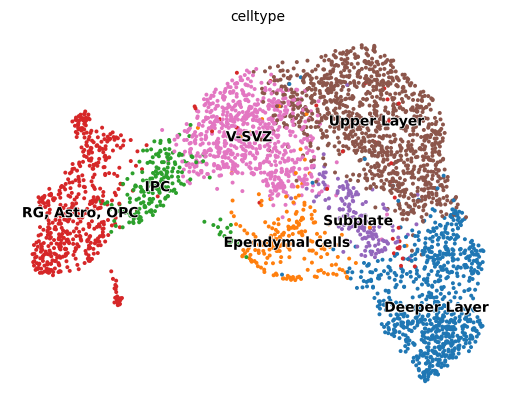

In [36]:
scv.tl.umap(adata)
scv.pl.umap(adata, color='celltype')

In [37]:
# specific configs to overide the default configs
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}},
    "trainer": {"verbosity": 0}, # increase verbosity to show training progress
}
configs = update_dict(Constants.default_configs, configs)

The ratio of spliced reads is 41.9% (less than 70%). Suggest using coeff_s 0.5.


In [38]:
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [39]:
velocity(adata, mask_zero=False)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [40]:
trainer = train(adata, configs)

Config Warning: Set to use GPU, but GPU version of DGL is not installed. Reset to use CPU instead.
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([3653, 2000])
confidence mse shape: (3653, 2000)
confidence mse stats: max 989.1204833984375, min 0.0, mean 0.6621717214584351, std 5.516257286071777
confidence corr shape: (2000,)
confidence corr stats: max 0.8115176558494568, min -0.335094690322876, mean 0.44813451170921326, std 0.11606365442276001
velo_mat shape: (3653, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


In [41]:
scv.tl.velocity_graph(adata, n_jobs=8)

computing velocity graph (using 8/24 cores)


  0%|          | 0/3653 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


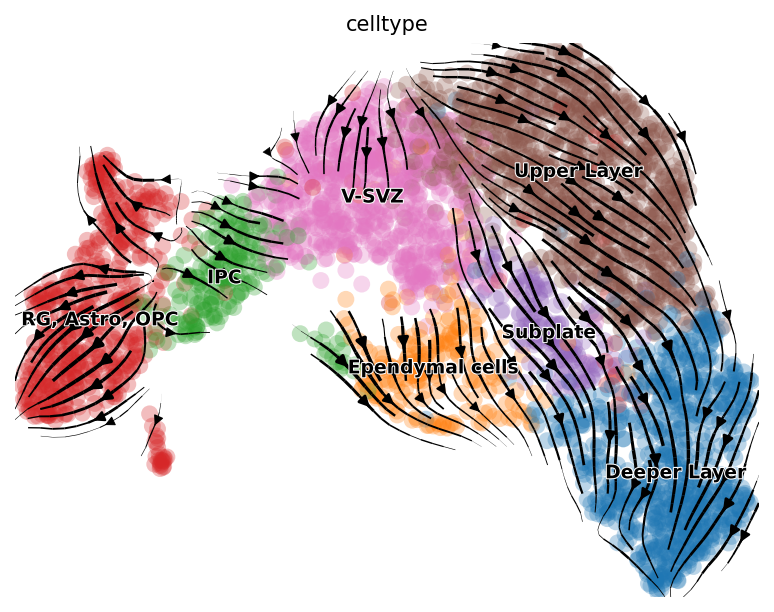

In [42]:
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    color="celltype",
    legend_fontsize=9,
    dpi=150            # increase dpi for higher resolution
)

In [43]:
scv.tl.velocity_pseudotime(adata)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [44]:
adata.write_h5ad("data/deepvelo.h5ad")